In [5]:
import numpy as np
import pandas as pd
from obspy import UTCDateTime
from HinetPy import Client
import os
from pathlib import Path

from volpick.data.utils import extract_events

def in_region(x,y,region):
    west=region[0]
    east=region[1]
    south=region[2]
    north=region[3]
    return (x>=west)&(x<=east)&(y>=south)&(y<=north)

In [221]:
regions=[[123.3,127.5,23.56,27.25],
        [131.9,133,31.6,33.7],
        [133,134.6,33.7,34.3],
        [135,137.6,33.7,34.9],
        [135.5,138.2,34.9,35.5],
        [140.5,140.7,36.6,36.8]
       ]

In [222]:
regions2=[[123.3,135,22,27.5],
        [141.7,159,21,42],
        [140.2,142,33.7,36.5],
        [140.7,142,36.5,37.5],
        [139.5,140.2,35.3,36.2],
        [131.7,134,27.5,33],
        [136,146,23.5,33.7],
        [141.9, 159, 42, 43],
        [129.6,131.7, 27.5, 29],
        [130.8, 131.7, 29, 30.8],
        [127,129.3,30.5,32.2],
        [127,136,36,45]
       ]
regions2=regions+regions2

# Reading data

In [2]:
cat=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_catalog.csv")

In [8]:
print(f"Number of traces: {len(cat)}")

Number of traces: 61574412


In [3]:
np.unique(cat["source_type"])

array(['artificial', 'eruption', 'insufficient', 'lp', 'natural'],
      dtype=object)

In [4]:
full_rg=cat[(cat["source_type"]=="eruption")|(cat["source_type"]=="natural")].copy()
full_rg.reset_index(inplace=True)
print(f"""Number of regular earthquakes waveforms: {len(full_rg)}""")

Number of traces: 61574412
Number of regular earthquakes waveforms: 60892473


In [6]:
full_rg=full_rg[pd.notna(full_rg["source_magnitude"])]
full_rg.reset_index(inplace=True)
print(f"""Number of regular earthquakes waveforms (after removing those with unknown magnitude): {len(full_rg)}""")

Number of regular earthquakes waveforms (after removing those with unknown magnitude): 60166469


In [9]:
full_lp=cat[cat["source_type"]=="lp"].copy()
full_lp.reset_index(inplace=True)

print(f"""Number of LP: {len(full_lp)}""")

Number of LP: 681875


In [10]:
full_lp=full_lp[pd.notna(full_lp["source_magnitude"])]
full_lp.reset_index(inplace=True)
print(f"""Number of LP (after removing those with unknown magnitude): {len(full_lp)}""")

Number of LP (after removing those with unknown magnitude): 655154


In [11]:
total_events=extract_events(cat)

In [12]:
print(f"{len(total_events)} events")
print(f"""{len(total_events[total_events["source_type"]=="lp"])} LP events""")
print(f"""{len(total_events[(total_events["source_type"]=="lp")&(pd.notna(total_events["source_magnitude"]))])} LP events with magnitudes""")

3580394 events
58005 LP events
55047 LP events with magnitudes


In [13]:
print(f"{len(total_events)} events")
print(f"""{len(total_events[(total_events["source_type"]=="eruption")|(total_events["source_type"]=="natural")])} regular events""")
print(f"""{len(total_events[((total_events["source_type"]=="eruption")|(total_events["source_type"]=="natural"))&(pd.notna(total_events["source_magnitude"]))])} regular events with magnitudes""")

3580394 events
3522387 regular events
3423880 regular events with magnitudes


# Selecting LP

In [20]:
# selecting LP data with both P and S arrivals
lp_with_P_and_S=cat[( cat["source_type"]=="lp" )&(pd.notna(cat["trace_p_arrival_time"]))&(pd.notna(cat["trace_s_arrival_time"]))]
print(len(lp_with_P_and_S))
print(f"""Empty magnitude: {len(lp_with_P_and_S[pd.isna(lp_with_P_and_S["source_magnitude"])])}""")
print(f"""Low reliability: {len(lp_with_P_and_S[~((lp_with_P_and_S["trace_p_flag"].str.isupper())&(lp_with_P_and_S["trace_s_flag"].str.isupper()))])}""")

lp_with_P_and_S=lp_with_P_and_S[pd.notna(lp_with_P_and_S["source_magnitude"])]

lp_with_P_and_S=lp_with_P_and_S[(lp_with_P_and_S["trace_p_flag"].str.isupper())&(lp_with_P_and_S["trace_s_flag"].str.isupper())]
print(f"Number of LPs with both P and S (after removing those with unknown magnitude and low reliability): {len(lp_with_P_and_S)}")

103210
Empty magnitude: 3537
Low reliability: 3
Number of LPs with both P and S (after removing those with unknown magnitude and low reliability): 99670


In [21]:
print(np.unique(lp_with_P_and_S["trace_p_flag"]))
print(np.unique(lp_with_P_and_S["trace_s_flag"]))

['A' 'B' 'E' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'X' 'Z']
['A' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'X' 'Z']


In [22]:
print(f"""Auto pick-up phases: {len(lp_with_P_and_S[(lp_with_P_and_S["trace_p_flag"]=="A")|(lp_with_P_and_S["trace_p_flag"]=="B")|(lp_with_P_and_S["trace_p_flag"]=="E")|(lp_with_P_and_S["trace_s_flag"]=="A")])}""")

Auto pick-up phases: 4418


In [10]:
print(sum(lp_with_P_and_S["trace_p_flag"].str.isupper()))
print(sum(lp_with_P_and_S["trace_s_flag"].str.isupper()))

99670
99670


In [11]:
selected_LP_events=extract_events(lp_with_P_and_S)
print(f"""Number of LP waveforms with both P and S manual picks: {len(lp_with_P_and_S)}, corresponding to {len(selected_LP_events)} events""")

Number of LP waveforms with both P and S manual picks: 99670, corresponding to 18580 events


In [12]:
# save
lp_with_P_and_S.reset_index(inplace=True,drop=True)
lp_with_P_and_S.to_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_LP_with_PS.csv",index=False)

Auto pick-up phases

In [24]:
lp_with_P_and_S_auto=lp_with_P_and_S[(lp_with_P_and_S["trace_p_flag"]=="A")|(lp_with_P_and_S["trace_p_flag"]=="B")|(lp_with_P_and_S["trace_p_flag"]=="E")|(lp_with_P_and_S["trace_s_flag"]=="A")]
print(f"Number of LP waveforms that have auto pick-up phases: {len(lp_with_P_and_S_auto)}")
lp_with_P_and_S_auto.reset_index(inplace=True, drop=True)
lp_with_P_and_S_auto.to_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_LP_with_PS_autopick.csv",index=False)

Number of LP waveforms that have auto pick-up phases: 4418


In [25]:
lp_with_P_and_S_auto

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag
0,J040413184918744249191404977,2004-04-13T18:49:18.740000Z,42.819833,140.829500,28.83,1.6,V,lp,NaN,N.MSAH,--,--,h,2004-04-13T18:49:35.600000Z,2004-04-13T18:49:46.860000Z,A,A
1,J040418030256763154661305563,2004-04-18T03:02:56.760000Z,31.911000,130.927167,22.00,0.3,V,lp,NaN,N.NRAH,--,--,h,2004-04-18T03:03:04.420000Z,2004-04-18T03:03:10.280000Z,A,M
2,J040506113953993624331371743,2004-05-06T11:39:53.990000Z,36.405500,137.290500,12.15,0.3,v,lp,NaN,N.KOKH,--,--,h,2004-05-06T11:39:56.600000Z,2004-05-06T11:39:58.260000Z,A,M
3,J040506113953993624331371743,2004-05-06T11:39:53.990000Z,36.405500,137.290500,12.15,0.3,v,lp,NaN,DP.KTJ,--,--,t,2004-05-06T11:39:57.060000Z,2004-05-06T11:39:59.310000Z,A,M
4,J040506113953993624331371743,2004-05-06T11:39:53.990000Z,36.405500,137.290500,12.15,0.3,v,lp,NaN,NIUKAW,--,--,N,2004-05-06T11:39:58.130000Z,2004-05-06T11:40:01.280000Z,A,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4413,J230626123814163743601401726,2023-06-26T12:38:14.160000Z,37.726667,140.287667,26.68,0.4,V,lp,NaN,N.MRUH,--,--,h,2023-06-26T12:38:21.150000Z,2023-06-26T12:38:26.310000Z,M,A
4414,J230626123814163743601401726,2023-06-26T12:38:14.160000Z,37.726667,140.287667,26.68,0.4,V,lp,NaN,N.KMYH,--,--,h,2023-06-26T12:38:21.810000Z,2023-06-26T12:38:27.250000Z,M,A
4415,J230626123814163743601401726,2023-06-26T12:38:14.160000Z,37.726667,140.287667,26.68,0.4,V,lp,NaN,MARUMO,--,--,N,2023-06-26T12:38:23.270000Z,2023-06-26T12:38:29.450000Z,M,A
4416,J230626123814163743601401726,2023-06-26T12:38:14.160000Z,37.726667,140.287667,26.68,0.4,V,lp,NaN,N.MKJH,--,--,h,2023-06-26T12:38:23.130000Z,2023-06-26T12:38:29.410000Z,A,A


In [32]:
vol_lp_fromfile=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/Vol_lp/mseed_log/downloads.csv")
lp_fromfile_autopick=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_LP_with_PS_autopick.csv")

In [44]:
vol_lp_with_autopick=vol_lp_fromfile[vol_lp_fromfile.apply(lambda x: (x["source_id"],x["station_code"]),axis=1).isin(lp_fromfile_autopick.apply(lambda x: (x["source_id"],x["station_code"]),axis=1))]

In [47]:
from volpick.data.utils import plot_waveforms
from pathlib import Path

In [ ]:
plot_waveforms(waveform_table=vol_lp_fromfile,
               data_dir="/mnt/DATA2/YiyuanZhong/my_data/Japan/Vol_lp/mseed",
               indices=np.arange(20),
               fig_dir=Path("/mnt/DATA2/YiyuanZhong/my_data/Japan/Vol_lp/some_figs"))

In [49]:
plot_waveforms(waveform_table=vol_lp_with_autopick,
               data_dir="/mnt/DATA2/YiyuanZhong/my_data/Japan/Vol_lp/mseed",
               indices=np.arange(20),
               fig_dir=Path("/mnt/DATA2/YiyuanZhong/my_data/Japan/Vol_lp/auto_pick_figs"),xrangemin=-2,xrangemax=2)

Plotting 20 figures


In [253]:
# aa=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_vol_LP_with_PS.csv")
# bb=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_tec_LP_with_PS.csv")
# print(len(aa))
# print(len(bb))

92977
6693


# Selecting regular earthquakes

In [14]:
# selecting regular earthquake data with both P and S arrivals
rg_with_P_and_S=cat[( (cat["source_type"]=="eruption")|(cat["source_type"]=="natural") )&(pd.notna(cat["trace_p_arrival_time"]))&(pd.notna(cat["trace_s_arrival_time"]))]
print(len(rg_with_P_and_S))
print(f"""Empty magnitude: {len(rg_with_P_and_S[pd.isna(rg_with_P_and_S["source_magnitude"])])}""")
print(f"""Low reliability: {len(rg_with_P_and_S[~((rg_with_P_and_S["trace_p_flag"].str.isupper())&(rg_with_P_and_S["trace_s_flag"].str.isupper()))])}""")

rg_with_P_and_S=rg_with_P_and_S[pd.notna(rg_with_P_and_S["source_magnitude"])]

rg_with_P_and_S=rg_with_P_and_S[(rg_with_P_and_S["trace_p_flag"].str.isupper())&(rg_with_P_and_S["trace_s_flag"].str.isupper())]
print(f"Number of LPs with both P and S (after removing those with unknown magnitude and low reliability): {len(rg_with_P_and_S)}")

38074080
Empty magnitude: 393760
Low reliability: 12398538
Number of LPs with both P and S (after removing those with unknown magnitude and low reliability): 25443107


In [16]:
print(np.unique(rg_with_P_and_S["trace_p_flag"]))
print(np.unique(rg_with_P_and_S["trace_s_flag"]))

['A' 'B' 'E' 'F' 'H' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'X' 'Z']
['A' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'X' 'Z']


In [18]:
print(f"""Auto pick-up phases: {len(rg_with_P_and_S[(rg_with_P_and_S["trace_p_flag"]=="A")|(rg_with_P_and_S["trace_p_flag"]=="B")|(rg_with_P_and_S["trace_p_flag"]=="E")|(rg_with_P_and_S["trace_p_flag"]=="F")|(rg_with_P_and_S["trace_p_flag"]=="H")|(rg_with_P_and_S["trace_s_flag"]=="A")])}""")

Auto pick-up phases: 8813401


In [19]:
rg_with_P_and_S=rg_with_P_and_S[~((rg_with_P_and_S["trace_p_flag"]=="A")|(rg_with_P_and_S["trace_p_flag"]=="B")|(rg_with_P_and_S["trace_p_flag"]=="E")|(rg_with_P_and_S["trace_p_flag"]=="F")|(rg_with_P_and_S["trace_p_flag"]=="H")|(rg_with_P_and_S["trace_s_flag"]=="A"))]
print(f"Number of regular earthquake waveforms with both P and S (after removing data with unknow magnitude, low reliability and auto pick-up phases): {len(rg_with_P_and_S)}")

Number of regular earthquake waveforms with both P and S (after removing data with unknow magnitude, low reliability and auto pick-up phases): 16629706


In [50]:
selected_RG_events=extract_events(rg_with_P_and_S)
print(f"""Number of regular earthquake waveforms with both P and S manual picks: {len(rg_with_P_and_S)}, corresponding to {len(selected_RG_events)} events""")

Number of regular earthquake waveforms with both P and S manual picks: 16629706, corresponding to 1844095 events


In [286]:
selected_RG_traces=rg_with_P_and_S[rg_with_P_and_S["station_code"].isin(vol_lp_fromfile["station_code"])]
selected_RG_traces.reset_index(inplace=True,drop=True)
print(len(selected_RG_traces))

10097921


In [298]:
print(len(selected_RG_traces))

10097921


In [299]:
selected_RG_events=extract_events(selected_RG_traces)
print(len(selected_RG_events))

1542470


In [325]:
# x=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_LP_with_PS.csv")
# print(len(x))
# print(len(extract_events(x)))

99670
18580


In [313]:
filter_mask=np.zeros(len(selected_RG_events),dtype=bool)
print(len(selected_RG_events))
print(len(filter_mask))
n_traces=80000
rand_idxs = np.sort(
    np.random.default_rng(seed=100).choice(
        len(selected_RG_events), size=n_traces, replace=False
    )
)
filter_mask[rand_idxs] = True
downsampled_regular_events=selected_RG_events[filter_mask]

downsampled_regular_traces=selected_RG_traces[selected_RG_traces["source_id"].isin(downsampled_regular_events["source_id"])]
print(len(downsampled_regular_events))
print(len(downsampled_regular_traces))
downsampled_regular_traces.reset_index(inplace=True,drop=True)

1542470
1542470
80000
523431


In [283]:
# filter_mask=np.zeros(len(selected_RG_traces),dtype=bool)
# print(len(selected_RG_traces))
# print(len(filter_mask))
# n_traces=500000
# rand_idxs = np.sort(
#     np.random.default_rng(seed=100).choice(
#         len(selected_RG_traces), size=n_traces, replace=False
#     )
# )
# filter_mask[rand_idxs] = True

# downsampled_regular_traces=selected_RG_traces[filter_mask]
# print(len(downsampled_regular_traces))
# downsampled_regular_traces.reset_index(inplace=True,drop=True)

10097921
10097921
500000


In [314]:
downsampled_regular_traces=downsampled_regular_traces[in_region(downsampled_regular_traces["source_longitude_deg"],downsampled_regular_traces["source_latitude_deg"],[123.2, 146, 23.5, 45.5])]
downsampled_regular_traces.reset_index(drop=True,inplace=True)
print(len(downsampled_regular_traces))

512236


In [315]:
region_mask=pd.Series([False]*len(downsampled_regular_traces))

for region in regions2:
    region_mask=region_mask|in_region(downsampled_regular_traces["source_longitude_deg"],downsampled_regular_traces["source_latitude_deg"],region)

In [316]:
downsampled_regular_traces=downsampled_regular_traces[~region_mask]
downsampled_regular_traces.reset_index(drop=True,inplace=True)

In [317]:
print(len(downsampled_regular_traces))
print(len(extract_events(downsampled_regular_traces)))

324285
46318


select VT near volcanoes

In [318]:
from obspy.geodetics import gps2dist_azimuth
def distance_to_volcano(ev_lat,ev_lon,vol_lat,vol_lon):
    dist, _, _ = gps2dist_azimuth(
        ev_lat,
        ev_lon,
        vol_lat,
        vol_lon,
    )
    return dist

In [319]:
vol=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/volcanoes/japan_active_vol_JMA.csv")
vol["lat"]=vol["lat_deg"]+vol["lat_min"]/60.0+vol["lat_sec"]/3600
vol["lon"]=vol["lon_deg"]+vol["lon_min"]/60.0+vol["lon_sec"]/3600

vol2=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/volcanoes/japan_active_vol2.csv")
# quaternary volcanoes
qua_vol=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/volcanoes/japan_qua_volcanoes.csv")
all_vol=pd.concat([vol,vol2,qua_vol],ignore_index=True)

In [320]:
downsampled_rg_events=extract_events(downsampled_regular_traces)
len(downsampled_rg_events)

46318

In [200]:
6378.137*np.cos(np.deg2rad(45))*np.deg2rad(0.65)

51.16459843180218

In [321]:
region_mask=pd.Series([False]*len(downsampled_rg_events))

vol_dist_thre=20e3
for lat, lon in zip(all_vol["lat"],all_vol["lon"]):
    def check_dist(x):
        if np.abs(x["source_latitude_deg"]-lat)>0.7 or np.abs(x["source_longitude_deg"]-lon)>0.7:
            return False
        else:
            return distance_to_volcano(x["source_latitude_deg"],x["source_longitude_deg"],lat,lon)<vol_dist_thre
        
    dist_mask=downsampled_rg_events.apply(check_dist, axis=1)
    region_mask=region_mask|dist_mask

In [324]:
downsampled_rg_events=downsampled_rg_events[region_mask]
downsampled_regular_traces=downsampled_regular_traces[downsampled_regular_traces["source_id"].isin(downsampled_rg_events["source_id"])]
downsampled_regular_traces.reset_index(drop=True,inplace=True)
print(len(downsampled_rg_events))
print(len(downsampled_regular_traces))

24640
186929


In [327]:
downsampled_rg_events=extract_events(downsampled_regular_traces)
print(len(downsampled_rg_events))

24640


In [335]:
random_filter_mask=np.zeros(len(downsampled_rg_events),dtype=bool)
rand_idxs = np.sort(
    np.random.default_rng(seed=1).choice(
        len(downsampled_rg_events), size=20000, replace=False
    )
)
random_filter_mask[rand_idxs] = True
downsampled_rg_events2=downsampled_rg_events[random_filter_mask]
downsampled_rg_events2.reset_index(drop=True,inplace=True)
downsampled_regular_traces2=downsampled_regular_traces[downsampled_regular_traces["source_id"].isin(downsampled_rg_events2["source_id"])]
print(len(downsampled_rg_events2))
print(len(downsampled_regular_traces2))

24640
24640
20000
151858


In [337]:
random_filter_mask=np.zeros(len(downsampled_regular_traces2),dtype=bool)
# print(len(downsampled_regular_traces2))
# print(len(random_filter_mask))
n_traces=93000
rand_idxs = np.sort(
    np.random.default_rng(seed=100).choice(
        len(downsampled_regular_traces2), size=n_traces, replace=False
    )
)
random_filter_mask[rand_idxs] = True

151858
151858


In [338]:
downsampled_regular_traces2=downsampled_regular_traces2[random_filter_mask]
downsampled_regular_traces2.reset_index(drop=True,inplace=True)
print(len(downsampled_regular_traces2))

93000


In [339]:
print(len(extract_events(downsampled_regular_traces2)))

19299


In [348]:
downsampled_regular_traces2.to_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_VT_with_PS.csv",index=False)

In [349]:
downsampled_regular_traces2

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag
0,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,OSHIM3,--,--,N,2004-04-01T03:47:53.930000Z,2004-04-01T03:47:58.380000Z,M,M
1,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,IZUSIM,--,--,N,2004-04-01T03:47:55.230000Z,2004-04-01T03:48:00.230000Z,M,M
2,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,N.MIZH,--,--,h,2004-04-01T03:47:55.300000Z,2004-04-01T03:48:00.260000Z,M,M
3,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,KAMAT2,--,--,N,2004-04-01T03:47:56.750000Z,2004-04-01T03:48:02.710000Z,N,N
4,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,N.NSI,--,--,s,2004-04-01T03:47:56.580000Z,2004-04-01T03:48:02.480000Z,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92995,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,IZUSIM,--,--,N,2023-06-19T00:54:32.390000Z,2023-06-19T00:54:37.780000Z,N,N
92996,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,N.NS2H,--,--,h,2023-06-19T00:54:33.840000Z,2023-06-19T00:54:40.040000Z,N,N
92997,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,ODAWA2,--,--,N,2023-06-19T00:54:36.050000Z,2023-06-19T00:54:43.750000Z,N,N
92998,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,N.ATGH,--,--,h,2023-06-19T00:54:38.180000Z,2023-06-19T00:54:48.020000Z,N,N


In [6]:
downloaded_vt=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/VT/mseed_log/downloads.csv")
downloaded_vt

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,...,trace_p_arrival_time,trace_s_arrival_time,station_latitude_deg,station_longitude_deg,station_elevation_m,station_epicentral_distance_m,path_azimuth_deg,path_back_azimuth_deg,trace_name,trace_sampling_rate_hz
0,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,OSHIM3,...,2004-04-01T03:47:53.930000Z,2004-04-01T03:47:58.380000Z,34.7208,139.4280,405.0,29996.194889,41.773013,221.896957,J040401034748303431161391259_OSHIM3.mseed,100
1,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,IZUSIM,...,2004-04-01T03:47:55.230000Z,2004-04-01T03:48:00.230000Z,34.7212,138.8750,135.0,38005.073480,306.197302,126.007071,J040401034748303431161391259_IZUSIM.mseed,100
2,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,N.MIZH,...,2004-04-01T03:47:55.300000Z,2004-04-01T03:48:00.260000Z,34.6749,138.8340,-50.0,38554.463616,296.697282,116.483882,J040401034748303431161391259_N.MIZH.mseed,100
3,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,KAMAT2,...,2004-04-01T03:47:56.750000Z,2004-04-01T03:48:02.710000Z,34.9285,139.0608,175.0,47399.200697,343.305449,163.220560,J040401034748303431161391259_KAMAT2.mseed,100
4,J040401034748303431161391259,2004-04-01T03:47:48.300000Z,34.519333,139.209833,11.79,1.3,V,natural,NaN,N.NSI,...,2004-04-01T03:47:56.580000Z,2004-04-01T03:48:02.480000Z,34.7903,138.8009,-422.0,48049.938416,308.841173,128.608641,J040401034748303431161391259_N.NSI.mseed,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85652,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,N.ATGH,...,2023-06-19T00:54:38.180000Z,2023-06-19T00:54:48.020000Z,35.4040,139.3539,-1788.0,71851.428717,4.827385,184.865642,J230619005425233445521391724_N.ATGH.mseed,100
85653,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,N.ITOH,...,2023-06-19T00:54:30.170000Z,2023-06-19T00:54:34.070000Z,34.9521,139.1379,-82.0,25441.052117,327.551865,147.466459,J230619005425233445521391724_N.ITOH.mseed,100
85654,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,OSHIM3,...,2023-06-19T00:54:27.900000Z,2023-06-19T00:54:29.410000Z,34.7208,139.4280,405.0,13548.878387,108.022632,288.102787,J230619005425233445521391724_OSHIM3.mseed,100
85655,J230619005425233445521391724,2023-06-19T00:54:25.230000Z,34.758667,139.287333,0.00,2.3,V,natural,NaN,N.JIZH,...,2023-06-19T00:54:31.340000Z,2023-06-19T00:54:35.810000Z,34.9161,138.9936,255.0,32044.547930,303.110485,122.942693,J230619005425233445521391724_N.JIZH.mseed,100


# Statics of the skipped records

In [13]:
unknown_event_format=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/skipped_events.csv")
unknown_station_format=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/skipped_stations.csv")
print(f"{len(unknown_event_format)}")
print(f"{len(unknown_station_format)}")

25898
477751


# Tectonic LP and volcanic LP

In [14]:
tec_mask1=pd.Series([False]*len(full_lp))
print(len(tec_mask1))

for region in regions:
    tec_mask1=tec_mask1|in_region(full_lp["source_longitude_deg"],full_lp["source_latitude_deg"],region)

655154


In [15]:
full_tec_lp=full_lp[tec_mask1]
full_vol_lp=full_lp[~tec_mask1]
full_tec_lp_events=extract_events(full_tec_lp)
full_vol_lp_events=extract_events(full_vol_lp)
print(f"""{len(full_vol_lp)} volcanic lp waveforms""")
print(f"""{len(full_tec_lp)} tectonic lp waveforms""")
print(f"""{len(full_vol_lp_events)} volcanic lp events""")
print(f"""{len(full_tec_lp_events)} tectonic lp events""")

280832 volcanic lp waveforms
374322 tectonic lp waveforms
20511 volcanic lp events
34536 tectonic lp events


In [16]:
print(f"""{len(full_tec_lp[((pd.notna(full_tec_lp["trace_p_arrival_time"]))&(pd.isna(full_tec_lp["trace_s_arrival_time"])))|
                           ((pd.isna(full_tec_lp["trace_p_arrival_time"]))&(pd.notna(full_tec_lp["trace_s_arrival_time"])))])} tectonic lp waveforms with only one pick""")

367629 tectonic lp waveforms with only one pick


In [17]:
lp_with_P_and_S

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag
0,J040401093647593617471373312,2004-04-01T09:36:47.590000Z,36.291167,137.552000,25.96,0.4,V,lp,NaN,N.KTRH,--,--,h,2004-04-01T09:36:51.900000Z,2004-04-01T09:36:54.860000Z,M,M
1,J040401093647593617471373312,2004-04-01T09:36:47.590000Z,36.291167,137.552000,25.96,0.4,V,lp,NaN,N.KOKH,--,--,h,2004-04-01T09:36:52.740000Z,2004-04-01T09:36:56.940000Z,M,M
2,J040401093647593617471373312,2004-04-01T09:36:47.590000Z,36.291167,137.552000,25.96,0.4,V,lp,NaN,DP.KTJ,--,--,t,2004-04-01T09:36:53.310000Z,2004-04-01T09:36:57.250000Z,M,M
3,J040401093647593617471373312,2004-04-01T09:36:47.590000Z,36.291167,137.552000,25.96,0.4,V,lp,NaN,NIUKAW,--,--,N,2004-04-01T09:36:53.110000Z,2004-04-01T09:36:56.590000Z,M,M
4,J040401094117283619771373498,2004-04-01T09:41:17.280000Z,36.329500,137.583000,29.08,0.2,V,lp,NaN,NIUKAW,--,--,N,2004-04-01T09:41:23.580000Z,2004-04-01T09:41:27.960000Z,M,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99665,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,N.YSDH,--,--,h,2023-06-27T19:37:57.100000Z,2023-06-27T19:38:02.370000Z,M,M
99666,J230627193749293515991331574,2023-06-27T19:37:49.290000Z,35.266500,133.262333,29.82,0.7,V,lp,NaN,N.TTAH,--,--,h,2023-06-27T19:37:57.460000Z,2023-06-27T19:38:03.160000Z,M,M
99667,J230628142303724249701411720,2023-06-28T14:23:03.720000Z,42.828333,141.286667,28.54,0.7,V,lp,NaN,ENIWA,--,--,N,2023-06-28T14:23:08.870000Z,2023-06-28T14:23:12.520000Z,N,N
99668,J230628142303724249701411720,2023-06-28T14:23:03.720000Z,42.828333,141.286667,28.54,0.7,V,lp,NaN,HU.HSS,--,--,%,2023-06-28T14:23:09.170000Z,2023-06-28T14:23:12.790000Z,N,M


In [18]:
tec_mask2=pd.Series([False]*len(lp_with_P_and_S))

for region in regions:
    tec_mask2=tec_mask2|in_region(lp_with_P_and_S["source_longitude_deg"],lp_with_P_and_S["source_latitude_deg"],region)
    
tec_lp=lp_with_P_and_S[tec_mask2]
vol_lp=lp_with_P_and_S[~tec_mask2]

In [19]:
print("If we only consider waveforms with both P and S manual labels.")
print(f"""{len(vol_lp)} volcanic lp waveforms""")
print(f"""{len(tec_lp)} tectonic lp waveforms""")
print(f"""{len(extract_events(vol_lp))} volcanic lp events""")
print(f"""{len(extract_events(tec_lp))} tectonic lp events""")

If we only consider waveforms with both P and S manual labels.
92977 volcanic lp waveforms
6693 tectonic lp waveforms
16140 volcanic lp events
2440 tectonic lp events


In [20]:
vol_lp.to_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_vol_LP_with_PS.csv",index=False)
tec_lp.to_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_tec_LP_with_PS.csv",index=False)

In [21]:
print(np.sum((vol_lp["station_type"]=="P")|(vol_lp["station_type"]=="Q")|(vol_lp["station_type"]=="R")))
print(np.sum((tec_lp["station_type"]=="P")|(tec_lp["station_type"]=="Q")|(tec_lp["station_type"]=="R")))

0
0


# Frequency index

In [7]:
import seisbench.data as sbd
import matplotlib.pyplot as plt

In [8]:
data_path=Path("/home/zhongyiyuan/DATA/my_datasets_seisbench/vcseis")

dataset=sbd.WaveformDataset(
        data_path,
        sampling_rate=100,
        component_order="ZNE",
        dimension_order="NCW",
        cache="full",
    )

In [12]:
dataset.filter((dataset.metadata["trace_chunk"]=='_japan_vol_lp')|(dataset.metadata["trace_chunk"]=='_japan_vt'),inplace=True)

In [13]:
print(dataset)
trace_with_spikes_index=np.flatnonzero(dataset.metadata["trace_has_spikes"].to_numpy())
print(f"{len(trace_with_spikes_index)} spikes")

Unnamed dataset - 166527 traces
0 spikes


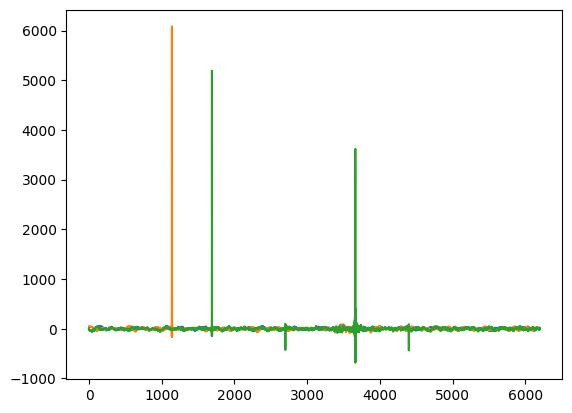

In [361]:
plt.plot(dataset.get_sample(trace_with_spikes_index[2])[0].T)

In [362]:
dataset.filter(~dataset.metadata["trace_has_spikes"],inplace=True)

In [17]:
dataset.metadata["source_type"]

421614         lp
421615         lp
421616         lp
421617         lp
421618         lp
           ...   
588136    natural
588137    natural
588138    natural
588139    natural
588140    natural
Name: source_type, Length: 166527, dtype: object

In [20]:
freq_indices=dataset.metadata.drop_duplicates(subset="source_id",keep="first",inplace=False)["source_frequency_index"].to_numpy()

lp_metadata=dataset.metadata[dataset.metadata["source_type"]=="lp"]
rg_metadata=dataset.metadata[dataset.metadata["source_type"]!="lp"]
print(len(lp_metadata))
print(len(rg_metadata))

# source id of lp events and frequency indexes of lp events
freq_indices_lp=lp_metadata.drop_duplicates(subset="source_id",keep="first",inplace=False)["source_frequency_index"].to_numpy()
freq_indices_rg=rg_metadata.drop_duplicates(subset="source_id",keep="first",inplace=False)["source_frequency_index"].to_numpy()

82583
83944


In [21]:
# frequency indexes of each trace
trace_freq_indices=dataset.metadata["trace_frequency_index"]
trace_freq_indices_lp=lp_metadata["trace_frequency_index"]
trace_freq_indices_rg=rg_metadata["trace_frequency_index"]
# validate
print(len(trace_freq_indices_rg)+len(trace_freq_indices_lp)==len(trace_freq_indices))
print(np.all(np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))==np.sort(trace_freq_indices)))
print(np.sum(np.sort(np.concatenate((trace_freq_indices_rg, trace_freq_indices_lp)))-np.sort(trace_freq_indices)))

True
True
0.0


max 1.4271116166472908
min -2.313452792819637


Text(0, 0.5, 'Count')

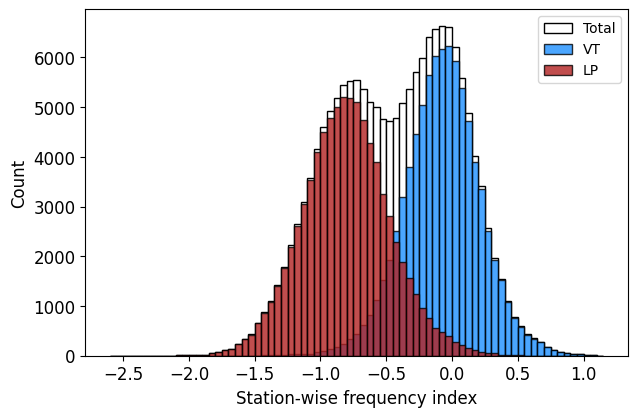

In [25]:
print(f"max {np.max(trace_freq_indices)}")
print(f"min {np.min(trace_freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.6, 1.2, 0.05)
plt.hist(trace_freq_indices,bins,density=False, stacked=True, color="white", edgecolor="black",label="Total")
plt.hist(trace_freq_indices_rg, bins, density=False,  edgecolor="black", color="dodgerblue", alpha=0.8, label="VT")
plt.hist(trace_freq_indices_lp, bins, density=False,  edgecolor="black", color="firebrick", alpha=0.8, label="LP")
plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-wise frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)
# plt.savefig(root_save_path/"FI_by_traces.jpg", bbox_inches="tight", dpi=600)
# plt.savefig(root_save_path/"FI_by_traces.eps", bbox_inches="tight", dpi=600)

max 1.4271116166472908
min -2.313452792819637


Text(0, 0.5, 'Count')

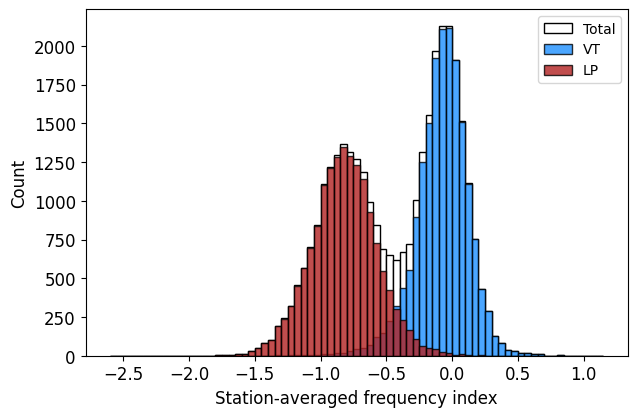

In [26]:
print(f"max {np.max(trace_freq_indices)}")
print(f"min {np.min(trace_freq_indices)}")
fts = 12
fig = plt.figure(figsize=(7, 4.5))

bins = np.arange(-2.6, 1.2, 0.05)
plt.hist(freq_indices,bins,density=False, stacked=True, color="white", edgecolor="black",label="Total")
plt.hist(freq_indices_rg, bins, density=False,  edgecolor="black", color="dodgerblue", alpha=0.8, label="VT")
plt.hist(freq_indices_lp, bins, density=False,  edgecolor="black", color="firebrick", alpha=0.8, label="LP")
plt.gca().tick_params(labelsize=fts)
plt.legend()
plt.xlabel("Station-averaged frequency index", fontsize=fts)
plt.ylabel("Count", fontsize=fts)

# 草稿区

In [9]:
vol_lp=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_vol_LP_with_PS.csv")

In [10]:
vol_lp.sort_values(by="source_origin_time", ignore_index=True, inplace=True)

In [26]:
len(vol_lp.drop_duplicates(subset="source_id", keep="first", ignore_index=True))

16140

In [22]:
org_times=vol_lp.drop_duplicates(subset="source_id", keep="first", ignore_index=True)["source_origin_time"].apply(lambda x: UTCDateTime(x)).values

In [23]:
np.diff(org_times)

array([269.69, 270716.81, 113357.63, ..., 30026.65, 111575.13, 67514.43],
      dtype=object)

In [19]:
np.argmax(np.diff(org_times))

35039

In [20]:
vol_lp["source_origin_time"].iloc[[35039,35040]]

35039    2011-11-08T22:27:56.470000Z
35040    2011-12-09T02:54:46.070000Z
Name: source_origin_time, dtype: object

In [4]:
tec_lp=pd.read_csv("/mnt/DATA2/YiyuanZhong/my_data/Japan/japan_tec_LP_with_PS.csv")

In [6]:
tec_lp[tec_lp["station_code"]=="NU.NIN"]

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag


In [8]:
vol_lp[vol_lp["station_code"]=="NU.NIN"]

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag


In [22]:
vol_lp[vol_lp["station_code"].str.contains("E.SOB3")]

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,station_type,trace_p_arrival_time,trace_s_arrival_time,trace_p_flag,trace_s_flag


In [58]:
failed_downloads=pd.read_csv("/home/zhongyiyuan/volpick/test/test_read_japan/mseed_log/failed_downloads.csv")

In [59]:
failed_downloads

,source_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_magnitude,source_magnitude_type,source_type,station_network_code,station_code,station_location_code,trace_channel,trace_p_arrival_time,trace_s_arrival_time,remark
0,J040406020657803616591373244,2004-04-06T02:06:57.800000Z,36.276500,137.540667,19.99,0.0,V,lp,NaN,N.KTRH,--,--,2004-04-06T02:07:01.130000Z,2004-04-06T02:07:03.950000Z,No_waveforms
1,J040406020657803616591373244,2004-04-06T02:06:57.800000Z,36.276500,137.540667,19.99,0.0,V,lp,NaN,N.KOKH,--,--,2004-04-06T02:07:02.110000Z,2004-04-06T02:07:05.910000Z,No_waveforms
2,J040406020657803616591373244,2004-04-06T02:06:57.800000Z,36.276500,137.540667,19.99,0.0,V,lp,NaN,DP.KTJ,--,--,2004-04-06T02:07:02.540000Z,2004-04-06T02:07:05.920000Z,No_waveforms
3,J040406020657803616591373244,2004-04-06T02:06:57.800000Z,36.276500,137.540667,19.99,0.0,V,lp,NaN,NIUKAW,--,--,2004-04-06T02:07:02.840000Z,2004-04-06T02:07:06.600000Z,No_waveforms
4,J040406020657803616591373244,2004-04-06T02:06:57.800000Z,36.276500,137.540667,19.99,0.0,V,lp,NaN,N.ASNH,--,--,2004-04-06T02:07:03.260000Z,2004-04-06T02:07:07.220000Z,No_waveforms
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,J040406020731533616251373471,2004-04-06T02:07:31.530000Z,36.270833,137.578500,23.42,0.6,V,lp,NaN,N.KOKH,--,--,2004-04-06T02:07:37.030000Z,2004-04-06T02:07:40.650000Z,No_waveforms
60,J040406020731533616251373471,2004-04-06T02:07:31.530000Z,36.270833,137.578500,23.42,0.6,V,lp,NaN,N.NGWH,--,--,2004-04-06T02:07:36.910000Z,2004-04-06T02:07:41.080000Z,No_waveforms
61,J040406020731533616251373471,2004-04-06T02:07:31.530000Z,36.270833,137.578500,23.42,0.6,V,lp,NaN,NU.YKD,--,--,2004-04-06T02:07:35.440000Z,2004-04-06T02:07:38.430000Z,No_waveforms
62,J040406020731533616251373471,2004-04-06T02:07:31.530000Z,36.270833,137.578500,23.42,0.6,V,lp,NaN,N.KTRH,--,--,2004-04-06T02:07:35.570000Z,2004-04-06T02:07:38.550000Z,No_waveforms
